# Testing Notebook

In this notebook, various functionalities of the developed Gaussian Process class are tested.

In [1]:
# Get path right
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\GaussianProcess")

import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Import GP regression module
from GPRegressor import GPRegressor

%matplotlib inline

## 1. Test GP interpolation ability

In [50]:
GP = GPRegressor(trend='Const', n_restarts=40)

In [38]:
# Check default attributes
GP.__dict__

{'verbose': False,
 'n_restarts': 40,
 'opt': 'L-BFGS-B',
 'init_point': None,
 'kernel': 'Gaussian',
 'trend': 'Quadratic',
 'nugget': 1e-10}

### 1.1 Create 1D test

In [30]:
# Define test function
def Test_1D(X):
    """1D Test Function"""
    
    y = (X*6-2)**2*np.sin(X*12-4)
    
    return y

In [51]:
# Training data
X_train = np.linspace(0.0, 1.0, 20).reshape(-1,1)
y_train = Test_1D(X_train) + np.sqrt(2)*np.random.randn(20,1)

# Testing data
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)
y_test = Test_1D(X_test)

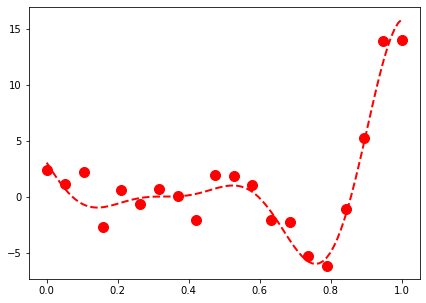

In [52]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test, y_test, 'r--', lw=2)
ax.plot(X_train, y_train, 'ro', markersize=10);

In [53]:
# Fit GP model
GP.fit(X_train, y_train)

In [54]:
# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)

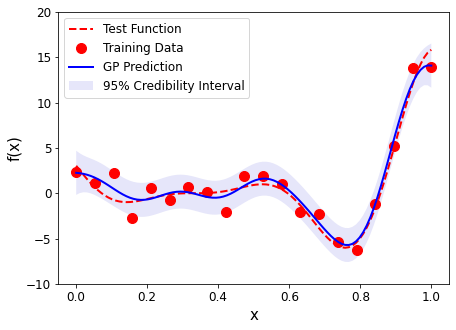

In [55]:
# Assess prediction results
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(X_test,y_pred,'b-', lw=2, label='GP Prediction')
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])
ax.legend(loc="upper left",prop={'size': 12});

In [56]:
GP.score(X_test, y_test)

0.6167385098580165

### 1.2 Test Generating realizations

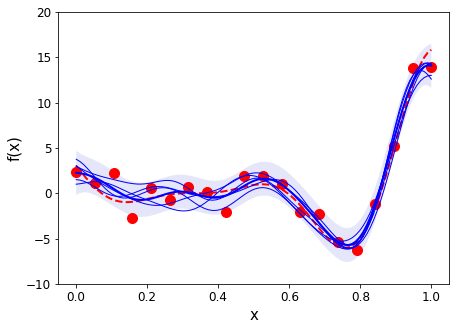

In [57]:
# Generate realizations
samples = GP.realizations(5, X_test)

# Post-processing
fig, ax = plt.subplots(figsize=(7,5))

# True function
ax.plot(X_test,y_test,'r--',linewidth=2)

# Training data
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10)

# Mean prediction
ax.plot(X_test,y_pred,'b-', lw=2)

# Display realizations
for i in range(samples.shape[0]):
    ax.plot(X_test, samples[i,:],'b-', lw=1)

# Display confidence bands
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender')

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20]);

### 1.2 Create 2D test

In [73]:
# 2D Test function
def Test_2D(X):
    """2D Test Function"""
    
    y = (1-X[:,0])**2 + (X[:,1]-X[:,0]**2)**2
    
    return y

In [74]:
# Training data
sample_num = 30
lb, ub = np.array([-2, -1]), np.array([2, 3])
X_train = (ub-lb)*lhs(2, samples=sample_num) + lb

# Compute labels
y_train = Test_2D(X_train).reshape(-1,1) + np.sqrt(2)*np.random.rand(sample_num, 1)

# Test data
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y_test = Test_2D(X_test)

Demonstrate training samples in 2D space

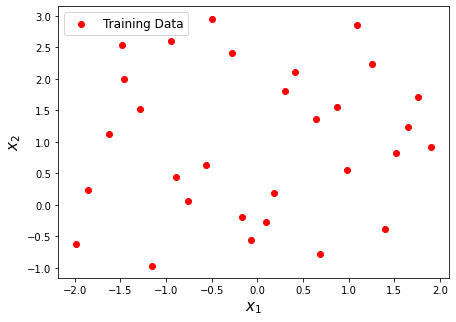

In [75]:
# Vislauzing training samples
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train[:,0], X_train[:,1], c='r', label='Training Data')
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
ax.legend(loc="upper left",prop={'size': 12});

In [76]:
%%time
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPRegressor(trend='Const', kernel='Gaussian', 
                               opt='L-BFGS-B',
                               n_restarts=20))])
pipe.fit(X_train, y_train)

Wall time: 2.15 s


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('GP', <GPRegressor.GPRegressor object at 0x00000236DB172FA0>)])

In [77]:
# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(X_test)

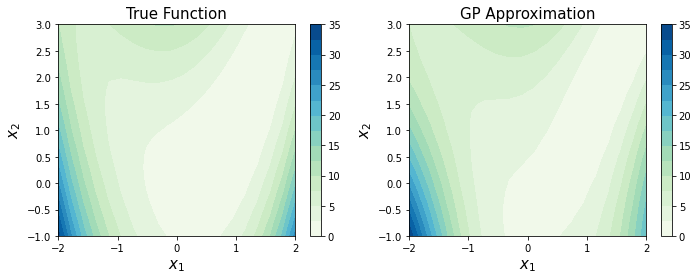

In [78]:
# Post-processing - Contour plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))
title = ['True Function', 'GP Approximation']
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   display_y[i].reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])
plt.tight_layout()

In [79]:
# Assess accuracy score
pipe.score(X_test, y_test)

1.1235073454383928

### 1.3 Create 3D test

In [27]:
# Define test function
def Test_3D(X):
    """2D Test Function"""
    
    y = (1-X[:,0])**2 + 100*(X[:,1]-X[:,0]**2)**2 + \
        (1-X[:,1])**2 + 100*(X[:,2]-X[:,1]**2)**2
    
    return y

In [28]:
# Test data
lb, ub = np.array([-2, -1, -2]), np.array([2, 3, 2])
X_test = (ub-lb)*lhs(3, samples=500) + lb
y_test = Test_3D(X_test)

# Train data
X_train = (ub-lb)*lhs(3, samples=60) + lb
y_train = Test_3D(X_train).reshape(-1,1)

# Specify initial points
initial_theta = [-0.8, -0.78, -1.]

In [ ]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPInterpolator(trend='Quadratic', n_restarts=50, optimizer='L-BFGS-B',
                              inital_point=initial_theta,
                              verbose=False))])
pipe.fit(X_train, y_train)

In [35]:
pipe[1].__dict__

{'n_restarts': 30,
 'optimizer': 'L-BFGS-B',
 'init_point': [-0.8, -0.78, -1.0],
 'kernel': 'Gaussian',
 'trend': 'Const',
 'nugget': 1e-10,
 'X': array([[0.66824255, 0.29421561, 0.60770644],
        [0.04187023, 0.85800459, 0.20394449],
        [0.98657227, 0.8609433 , 0.24579972],
        [0.0915312 , 0.78386415, 0.75959892],
        [0.42269368, 0.40648661, 0.01921103],
        [0.8434863 , 0.34424427, 0.56279826],
        [0.95553955, 0.50385965, 0.98346352],
        [0.27580049, 0.9664477 , 0.31765969],
        [0.30647651, 0.2267013 , 0.        ],
        [0.02304825, 0.99610534, 0.05190072],
        [0.10854705, 0.0905473 , 0.62830475],
        [0.2025837 , 0.82313046, 0.08303913],
        [0.06291474, 0.95562213, 0.5089296 ],
        [0.93239223, 0.03359873, 0.81516804],
        [0.94180687, 0.52929557, 0.5695245 ],
        [0.78696338, 0.61952152, 0.42003479],
        [0.4011491 , 0.65463024, 0.03341561],
        [0.77719317, 0.05347427, 0.89037252],
        [0.18127895, 0.247

In [30]:
# Assess accuracy score
pipe.score(X_test, y_test)

6.881184389527309